# ISOCS 2023 Data Challenge: Detect and Classify Odour Events

In [1]:
# Import relevant functions
from odour_detection import *

We first load the ground truth labels of the training data. This is used for visualising the training data and for giving us guidance on the appropriate selection of event detection and classification algorithms. 

In [2]:
# Load ground truth
path_training_labels = 'data/Training_Dataset_ISOCSWinterSchool2023.csv'
labels = load_training_labels(path_training_labels)

# List labels in their occuring order (manually)
y_train_all = np.array(['slalom', 'slalom', 'slalom', 'slalom', 'giant_slalom', 'downhill', 'giant_slalom', 'giant_slalom', 'downhill', 'downhill', 'giant_slalom', 'downhill'])

We then load the training data, and display some relevant sensors together with the extracted labels. 

In [3]:
# Load training data
path_training = 'data/WT1-30146.csv'
df = load_data(path_training, labels)

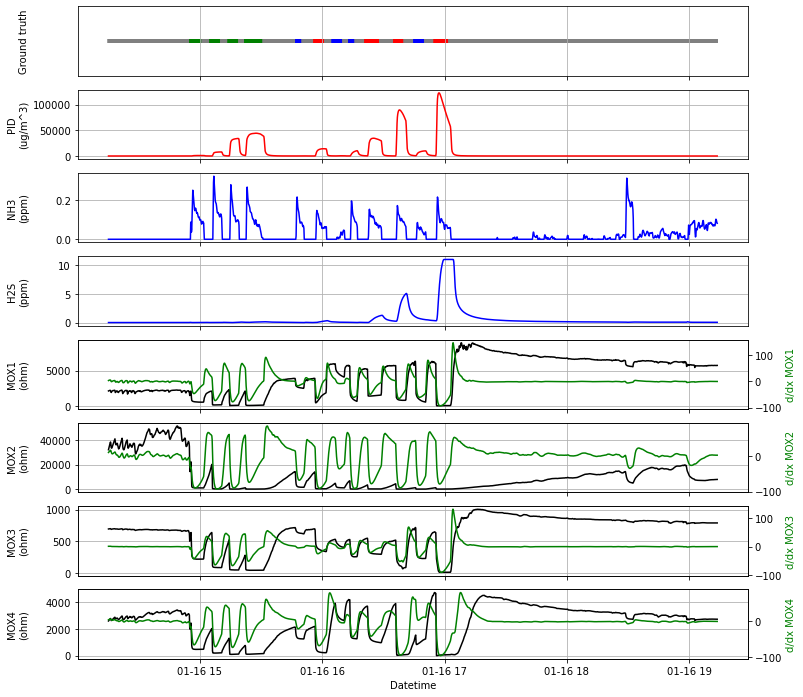

In [4]:
# Show training data
exploration(df, show_events=False, show_groundtruth=True)

### Description

In the above plot, we see the different sensors reacting to gas stimuli. While the actual chemical components are not known to us, we know that there are four odour events for each of the three classes, in the top-row indicated in green, blue and red. 

The different sensors are:
* Photoionisation Detector (*PID*)
* 2x electro-chemical sensors (*NH3* & *H2S*)
* 4x Metal-Oxide Gas Sensors (*MOX1*-*MOX4*)

In green, the first derivative of each *MOX* sensor signal is displayed and normalised (shown in a relative signal). 

### Observations

* We observe, that *NH3* reacts to all odour stimuli and thus could be used as an odour event detector. However, towards the end of the visible time series, a strong and increasing noise presence is evident, as well as a false-positive detection. 

* When zooming in on the *PID* signal (not shown here), a response to all odour events is evident, which is clearly above the level of noise. 

* It appears that the *MOX* sensors are affected by baseline drift, however they seem to react differently to different odour presentations (which is what we are looking for!). The first derivative is not affected by the drift, hence it will be useful in the discrimination task. Also, *H2S* seems to be selective to one class and thus can be used as well. 

### Strategy

* From the observation above, I decide to exclude *NH3* from the further analysis, as it might not be the most reliable (a discussion with the sensor experts confirmed this assumption). 

* In order to detect the odour onset, I take the first derivative of the *PID* and then search for local maximas. 

* Aiming to find meaningful and distinguishable data features, I define a [-1min, 6min] window around each detected odour onset. I then extract the coefficients of a polynomial fit (5th degree) for each raw *MOX* data, as well as the full *MOX*'s derivatives data and the *H2S* data. Flattened as an array, this will be my classification feature for each odour presentation.

* Given that we have only 12 training samples, which are not randomly spaced, any cross-validation approach will have its limits. In this case, I decide for a stratified leave-one-out Cross-Validation. It is important to note, that any score achieved with this, should not be reported as the final classifier score, but be merely a metric that allows for internal model optimisation. There is a separate test data set, that has been unknown to me during the developent of this pipeline, and that will be used to validate the performance of it.

* I will use a Support-Vector-Machine (SVM) as a classifier. While one generally has to be careful when using SVM for time-series (it does not assume any correlation between the data points, which of course one should when considering time-series), I decide for it anyway for two reasons:
    * When observing the data, the characteristic sharp sensor response decay is phase-locked with the event-detection time. Thus, given a fixed window, it should always appear at more-or-less the same position.
    * The SVM is known to converge to a solution, even when applied to a relatively small dataset. 

In [5]:
# Extract events 
events, index_events = detect_events(df)

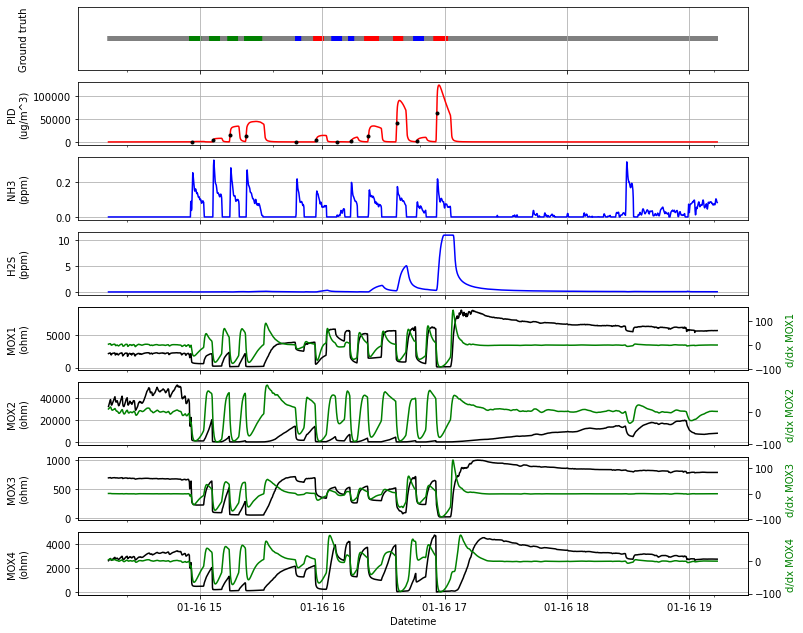

In [6]:
# Show events on training data
exploration(df, show_events=True, show_groundtruth=True)

Indeed, after playing around with the threshold, it appears that the odour event detection works well using the 1st derivative of the *PID* data.

In [7]:
# Extract features and build training set
X_train_all = get_features(df, events)
assert len(X_train_all)==len(y_train_all)

In [8]:
# Cross-validated training
train_idxs = [
    [2, 7, 9, 1, 6, 8, 0, 4, 5], 
    [3, 10, 11, 1, 6, 8, 0, 4, 5], 
    [3, 10, 11, 2, 7, 9, 0, 4, 5], 
    [3, 10, 11, 2, 7, 9, 1, 6, 8]
    ]
val_idxs = [
    [3, 10, 11], 
    [2, 7, 9], 
    [1, 6, 8], 
    [0, 4, 5]
    ]
accuracies, f1_scores = train_validate(X_train_all, y_train_all, train_idxs, val_idxs)

print(f"\n Validation:")
print(f"\t Accuracy: {np.mean(accuracies):2f} pm {np.std(accuracies):2f}")
print(f"\t F1 Score: {np.mean(f1_scores):2f} pm {np.std(f1_scores):2f}")


 Validation:
	 Accuracy: 0.916667 pm 0.144338
	 F1 Score: 0.888889 pm 0.192450


The reported accuracy and F1 scores hint at a working classification pipeline. Now, the model will be trained again with the full training data.

In [9]:
# Training on all training data
scaler, classifier = train_full(X_train_all, y_train_all)

We can now load the testing data and perform similar visualisations as before.

In [10]:
# Load testing data
path_testing = 'data/WT1-30146_final.csv'
df_test = load_data(path_testing)

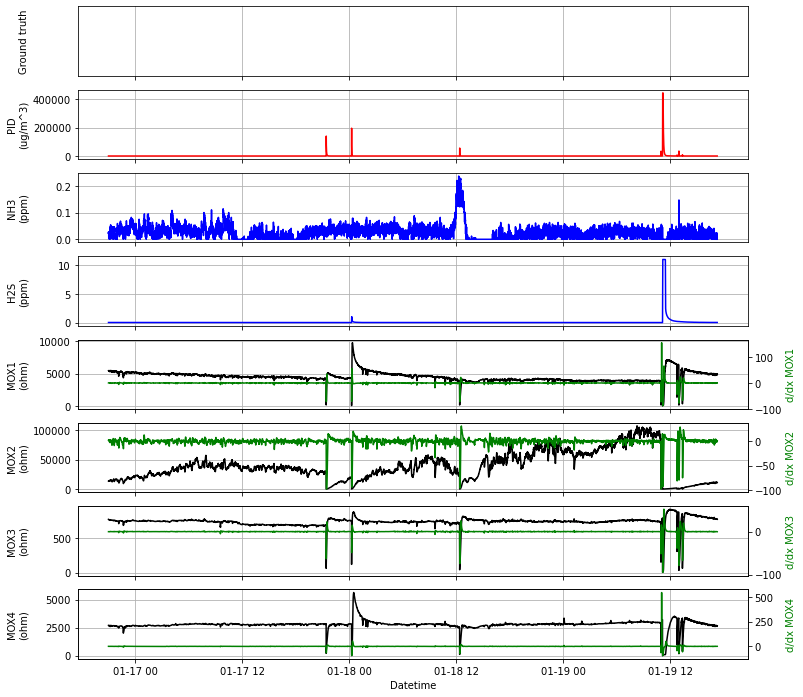

In [11]:
# Explore test data
exploration(df_test, show_events=False, show_groundtruth=False)

In [12]:
# Extract events 
events, index_events = detect_events(df_test)

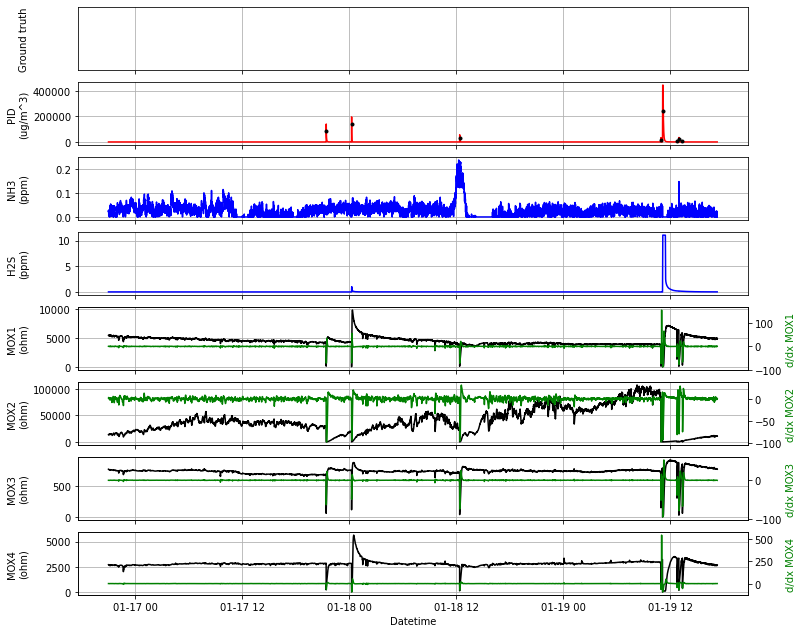

In [13]:
# Show events on training data
exploration(df_test, show_events=True, show_groundtruth=False)

It appears that multiple odour events are being detected. I will proceed in extracting the features and predicting the classes with the trained classifier.

In [14]:
# Extract features and build training set
X_test = get_features(df_test, events)

In [15]:
# Test trained model on test data
y_test_pred = test_predict(X_test, scaler, classifier)

print(f"\n Prediction:")
print(f"\t {y_test_pred}")
print(f"at {list(index_events)} respectively\n ") 
    


 Prediction:
	 ['slalom' 'downhill' 'slalom' 'slalom' 'downhill' 'giant_slalom' 'slalom'
 'giant_slalom']
at [Timestamp('2023-01-17 21:24:30'), Timestamp('2023-01-18 00:15:10'), Timestamp('2023-01-18 12:22:10'), Timestamp('2023-01-19 10:56:00'), Timestamp('2023-01-19 11:06:50'), Timestamp('2023-01-19 12:44:10'), Timestamp('2023-01-19 12:56:50'), Timestamp('2023-01-19 13:20:30')] respectively
 


After submission of the model, the ISOCS 2023 DataChallenge organisers revealed the ground truth labels of the test data. All odour presentations were detected, and, except for the first instance, classified correcty. 

In [16]:
y_test_groundtruth = ['giant_slalom', 'downhill', 'slalom', 'slalom', 'downhill', 'giant_slalom', 'slalom', 'giant_slalom']

In [18]:
print(f"\t Accuracy: {accuracy_score(y_test_pred, y_test_groundtruth):2f}")
print(f"\t F1 Score: {f1_score(y_test_pred, y_test_groundtruth, average='weighted'):2f}")

	 Accuracy: 0.875000
	 F1 Score: 0.878571
